In [1]:
# # Load Huggingface transformers
# from transformers import TFBertModel,  BertConfig, BertTokenizerFast, TFAutoModel

# # Then what you need from tensorflow.keras
# from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D, BatchNormalization
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.initializers import TruncatedNormal
# from tensorflow.keras.losses import CategoricalCrossentropy
# from tensorflow.keras.metrics import CategoricalAccuracy
# from tensorflow.keras.utils import to_categorical

# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
import tensorflow as tf
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import average_precision_score, precision_score

# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression

In [2]:
#pip install tensorflow-addons

In [3]:
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

In [4]:
RANDOM_SEED = 42

In [5]:
df=pd.read_csv('../input/cp-news/data.csv')
#df = df.sample(frac=1)

In [6]:
df.head()

,text,release_points,technical_update_points,partnership_points,listing_points,security_points,from_the_project,not_from_the_project,staking
0,We'd like to remind everyone that our $BONDLY ...,0,0,0,0,1,1,0,0
1,I’d like to share the recently completed smart...,0,0,0,0,1,0,0,0
2,@LuckyBartlett We'll be releasing details soon...,0,1,0,0,0,0,0,0
3,Today we're taking the time to acknowledge our...,1,1,0,0,1,0,0,0
4,Business continuity has been a huge focus in o...,1,0,1,0,1,0,1,0


# BERT

In [7]:
dataset = pd.read_csv('../input/cp-news/data.csv')
dataset

,text,release_points,technical_update_points,partnership_points,listing_points,security_points,from_the_project,not_from_the_project,staking
0,We'd like to remind everyone that our $BONDLY ...,0,0,0,0,1,1,0,0
1,I’d like to share the recently completed smart...,0,0,0,0,1,0,0,0
2,@LuckyBartlett We'll be releasing details soon...,0,1,0,0,0,0,0,0
3,Today we're taking the time to acknowledge our...,1,1,0,0,1,0,0,0
4,Business continuity has been a huge focus in o...,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
1207,Michelle Phan Interview - Toxic Bitcoin Maxima...,0,0,0,0,0,0,0,0
1208,Why Are Bitcoin Spot Volumes Shockingly Low Wh...,0,0,0,0,0,0,0,0
1209,Bitcoin skyrockets to over $69K as inflationar...,0,0,0,0,0,0,0,0
1210,"Price analysis 11/10: BTC, ETH, BNB, ADA, SOL,...",0,0,0,0,0,1,0,0


In [8]:
texts = list(dataset["text"])
label_names = dataset.drop(["text"], axis=1).columns
labels = dataset[label_names].values

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.15, random_state=42
)

sample_idx = 23
print(f'Sample: "{train_texts[sample_idx]}"')
print(f"Labels: {pd.Series(train_labels[sample_idx], label_names).to_dict()}")

Sample: "Dallas Mavericks fan wins $100k in Bitcoin at NBA shootout event"
Labels: {'release_points': 0, 'technical_update_points': 0, 'partnership_points': 0, 'listing_points': 0, 'security_points': 0, 'from_the_project': 0, 'not_from_the_project': 0, 'staking': 0}


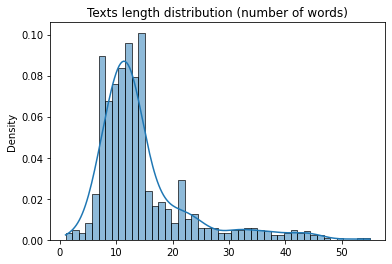

In [9]:
import seaborn as sns

text_lengths = [len(t.split()) for t in train_texts]
ax = sns.histplot(data=text_lengths, kde=True, stat="density")
ax.set_title("Texts length distribution (number of words)");

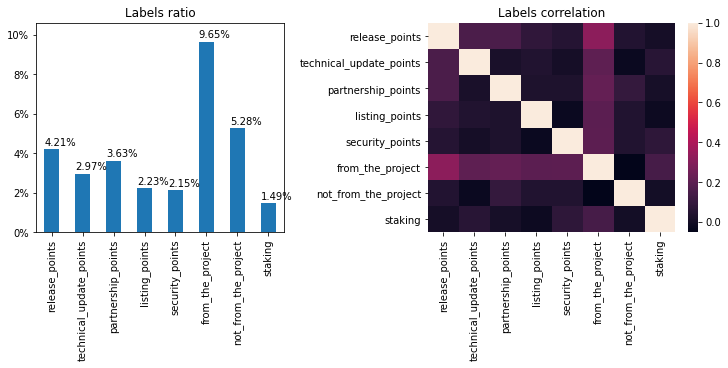

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Labels distribution barplot
labels_ratio = dataset[label_names].mean()
labels_ratio.plot(kind="bar", ax=ax1)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=False))
for p in ax1.patches:
    ax1.set_ylim(0, 1.1 * labels_ratio.max())
    ax1.annotate(f"{p.get_height():.2%}", (p.get_x() + 0.005, p.get_height() + 0.002))
ax1.set_title("Labels ratio");

# Labels correlation heatmap
ax2 = sns.heatmap(dataset[label_names].corr())
ax2.set_title("Labels correlation")
fig.show()

In [11]:
import numpy as np  
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, average_precision_score

pd.set_option("display.precision", 3)

dummy = DummyClassifier(strategy="prior")
dummy.fit(train_texts, train_labels)
y_pred = dummy.predict(test_texts)
y_prob = dummy.predict_proba(test_texts)
y_prob = np.array(y_prob)[:, :, 1].T

def compute_metrics(y_true: np.array, y_prob: np.array) -> pd.Series:
    """Compute several performance metrics for multi-label classification. """
    y_pred = y_prob.round()
    metrics = dict()
    metrics["Multi-label accuracy"] = np.all(y_pred == y_true, axis=1).mean()
    metrics["Binary accuracy"] = (y_pred == y_true).mean()
    metrics["Loss"] = log_loss(y_true, y_prob)
    metrics["Average Precision"] = average_precision_score(y_true, y_prob)
    return pd.Series(metrics)

evaluation = compute_metrics(test_labels, y_prob).to_frame(name="Dummy")
evaluation

,Dummy
Multi-label accuracy,0.786
Binary accuracy,0.960
Loss,0.640
Average Precision,0.040


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

# We take into account unigrams and bigrams that occur at least 10 times 
# in the train set, but less than 50 % of the time
tfidf = TfidfVectorizer()#min_df=10, max_df=0.5, ngram_range=(1, 2))

# We set the (L2) regularization weight to 1/2 (inverse of C)
classifier = OneVsRestClassifier(LogisticRegression(C=12., max_iter=1000))

baseline = make_pipeline(tfidf, classifier)
baseline.fit(train_texts, train_labels)

y_prob = baseline.predict_proba(test_texts)

evaluation["Baseline"] = compute_metrics(test_labels, y_prob)
evaluation

,Dummy,Baseline
Multi-label accuracy,0.786,0.780
Binary accuracy,0.960,0.959
Loss,0.640,0.547
Average Precision,0.040,0.341


In [13]:
train_labels.shape

(1030, 8)

In [14]:
import transformers
print(f"Transformers package version: {transformers.__version__}")

Transformers package version: 4.6.1


In [15]:
import tensorflow_addons as tfa

In [16]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, \
    DistilBertConfig, DistilBertTokenizerFast

MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 50  # We truncate anything after the 200-th word to speed up training

# The configuration is not needed if you don't have to customize the 
# network architecture. Here we will need it to replacee the output of the model
# with a multi-label prediction layer (i.e. sigmoid activations + binary cross-entropy
# instead of softmax + categorical cross-entropy of multi-class classification)
config = DistilBertConfig.from_pretrained(MODEL_NAME)

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)


train_encodings = tokenizer(train_texts, truncation=True, padding=True, 
                            max_length=MAX_LENGTH, return_tensors="tf")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, 
                           max_length=MAX_LENGTH, return_tensors="tf")

# Create TensorFlow datasets to feed the model for training and evaluation
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

# Tokenizer output example
sample_text = "heating up the frying pans for this week s burn reminder that due to frequent bsc node issues we ve moved the"
tokenizer.decode(tokenizer(sample_text)["input_ids"])

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

'[CLS] heating up the frying pans for this week s burn reminder that due to frequent bsc node issues we ve moved the [SEP]'

In [17]:
config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.6.1",
  "vocab_size": 30522
}

In [18]:
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

transformer_model = TFDistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, output_hidden_states=False
)

# transformer_model = TFAutoModel.from_pretrained(
#     MODEL_NAME, output_hidden_states=False
# )

bert = transformer_model.layers[0]

# The input is a dictionary of word identifiers 
input_ids = Input(shape=(MAX_LENGTH,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Here we select the representation of the first token ([CLS]) for classification
# (a.k.a. "pooled representation")
bert_model = bert(inputs)[0][:, 0, :] 

# Add a dropout layer and the output layer
#dropout = Dropout(0.1, name='pooled_output')
pooled_output = Dropout(0.1, name='pooled_output')(bert_model, training=False)
#head = Dense(256, activation="relu", 
#             kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
#            )(pooled_output)
#head = Dropout(0.5)(head)
output = Dense(
    units=train_labels.shape[1],
    #kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
    activation="sigmoid",  # Choose a sigmoid for multi-label classification
    name='output'
)(pooled_output)

model = Model(inputs=inputs, outputs=output, name='BERT_MultiLabel')
model.summary()

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "BERT_MultiLabel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
distilbert (TFDistilBertMain TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
output (Dense)               (None, 8)                 6152      
Total params: 66,369,032
Trainable params: 66,369,032
Non-trainable params: 0
_________________________________________________________________


In [19]:
len(model.layers)

5

In [20]:
# for layer in model.layers:
#     layer.trainable =  True

In [21]:
model.summary()

Model: "BERT_MultiLabel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
distilbert (TFDistilBertMain TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
output (Dense)               (None, 8)                 6152      
Total params: 66,369,032
Trainable params: 66,369,032
Non-trainable params: 0
_________________________________________________________________


In [22]:
optimizer = tfa.optimizers.RectifiedAdam(lr=1e-5)
#optimizer = Adam(0.00001)

In [23]:
#loss = tf.keras.losses.CategoricalCrossentropy() #tf.keras.losses.BinaryCrossentropy()
loss = tf.keras.losses.BinaryCrossentropy()

In [24]:
#loss = BinaryCrossentropy()
#optimizer = Adam(0.0001)
metrics = [
    multi_label_accuracy,
    "binary_accuracy", 
    AUC(name="average_precision", curve="PR", multi_label=True)
]

In [25]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
training_history = model.fit(
    train_dataset.shuffle(300).batch(16), 
    epochs=50, 
    batch_size=16, 
    validation_data=test_dataset.batch(16)
)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['attention_mask'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


65/65 [==============================] - 30s 131ms/step - loss: 0.7343 - multi_label_accuracy: 0.0347 - binary_accuracy: 0.4451 - average_precision: 0.0466 - val_loss: 0.3300 - val_multi_label_accuracy: 0.6684 - val_binary_accuracy: 0.9203 - val_average_precision: 0.0867
Epoch 2/50
65/65 [==============================] - 7s 105ms/step - loss: 0.2501 - multi_label_accuracy: 0.7333 - binary_accuracy: 0.9457 - average_precision: 0.0730 - val_loss: 0.1780 - val_multi_label_accuracy: 0.7622 - val_binary_accuracy: 0.9609 - val_average_precision: 0.0822
Epoch 3/50
65/65 [==============================] - 7s 102ms/step - loss: 0.1672 - multi_label_accuracy: 0.7958 - binary_accuracy: 0.9619 - average_precision: 0.0655 - val_loss: 0.1621 - val_multi_label_accuracy: 0.7622 - val_binary_accuracy: 0.9602 - val_average_precision: 0.0938
Epoch 4/50
65/65 [==============================] - 7s 100ms/step - loss: 0.1580 - multi_label_accuracy: 0.7871 - binary_accuracy: 0.9611 - average_precision: 0.083

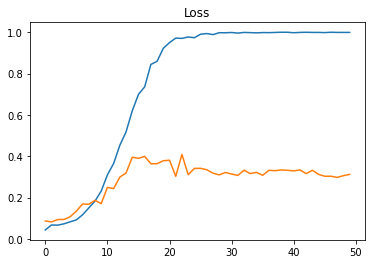

In [26]:
plt.title('Loss')
plt.plot(training_history.history['average_precision'], label='train')
plt.plot(training_history.history['val_average_precision'], label='test')
plt.show();

In [27]:
benchmarks = model.evaluate(
    test_dataset.batch(16), return_dict=True, batch_size=16
)

12/12 [==============================] - 0s 33ms/step - loss: 0.2050 - multi_label_accuracy: 0.7552 - binary_accuracy: 0.9602 - average_precision: 0.3123


In [28]:
evaluation["DistillBERT"] = [
    benchmarks[k] for k in 
    ["multi_label_accuracy", "binary_accuracy", "loss", "average_precision"]
]
evaluation

,Dummy,Baseline,DistillBERT
Multi-label accuracy,0.786,0.780,0.755
Binary accuracy,0.960,0.959,0.960
Loss,0.640,0.547,0.205
Average Precision,0.040,0.341,0.312


In [29]:
evaluation["DistillBERT"] = [
    benchmarks[k] for k in 
    ["multi_label_accuracy", "binary_accuracy", "loss", "average_precision"]
]
evaluation

,Dummy,Baseline,DistillBERT
Multi-label accuracy,0.786,0.780,0.755
Binary accuracy,0.960,0.959,0.960
Loss,0.640,0.547,0.205
Average Precision,0.040,0.341,0.312


In [30]:
model.save(f"fine_tuned_distilbert")

In [31]:
model.save("model.h5")

# Predict Sample

In [32]:
from time import time
from tensorflow.keras.models import load_model
from transformers import DistilBertTokenizerFast

# Mimicking a production scenario: load the model and tokenizer
#MAX_LENGTH = 70
model = load_model(f"fine_tuned_distilbert", 
                   custom_objects={"multi_label_accuracy": multi_label_accuracy})
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def score_text(text, model, tokenizer):
    padded_encodings = tokenizer.encode_plus(
        text,
        max_length=MAX_LENGTH, # truncates if len(s) > max_length
        return_token_type_ids=True,
        return_attention_mask=True,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    return model(padded_encodings["input_ids"]).numpy()

score_text("dummy")  # running a dummy prediction as a work-around the extra latency 
# of the first prediction of a loaded TensorFlow model.

text = """heating up the frying pans for this week s burn reminder that due to frequent bsc node issues we ve moved the"""

t0 = time()
scores = score_text(text)[0]
latency = time() - t0

scores = pd.Series(scores, label_names, name="scores")
print(scores.to_frame())
print(f"\nLatency: {latency:.3f} seconds")

                            scores
release_points           1.333e-03
technical_update_points  1.169e-03
partnership_points       1.849e-04
listing_points           9.272e-05
security_points          4.862e-04
from_the_project         7.310e-04
not_from_the_project     5.942e-05
staking                  3.037e-04

Latency: 0.051 seconds


In [33]:
dataset.iloc[0][0]

"We'd like to remind everyone that our $BONDLY token contract remains compromised by an unknown attacker and we ask you to refrain from trading our token until we have redeployed our new token. \n\nMore details here: https://t.co/WuSSNt2bsH"

In [34]:
t0 = time()
scores = score_text(dataset.iloc[0][0])[0]
latency = time() - t0

scores = pd.Series(scores, label_names, name="scores")
print(scores.to_frame())
print(f"\nLatency: {latency:.3f} seconds")

                            scores
release_points           7.931e-03
technical_update_points  7.833e-03
partnership_points       5.931e-03
listing_points           8.316e-04
security_points          9.943e-01
from_the_project         9.954e-01
not_from_the_project     2.098e-03
staking                  8.182e-03

Latency: 0.052 seconds


# Metrics

In [35]:
predictions = model.predict(test_dataset.batch(16) ,batch_size=64)
predictions_probes = pd.DataFrame(predictions)
predictions_probes.columns = label_names

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['attention_mask'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [36]:
y_test_df = pd.DataFrame(test_labels)
y_test_df.columns = label_names

In [37]:
random_score = {}

for label in label_names:
    y_test = y_test_df[label].copy()
    predict_proba_test_X = predictions_probes[label]
    pred_test_X = predict_proba_test_X > 0.5

    random_score[label] = {}
    random_score[label]['accuracy'] = round(accuracy_score(y_test, pred_test_X),4)
    random_score[label]['precision'] = round(precision_score(y_test, pred_test_X),4)
    random_score[label]['average_precision'] = round(average_precision_score(y_test, predict_proba_test_X),4)
    random_score[label]['F1'] = round(f1_score(y_test, pred_test_X),4)
    random_score[label]['AUC'] = round(roc_auc_score(y_test, predict_proba_test_X),4)
    
pd.DataFrame(random_score).T.mean().round(4)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy             0.960
precision            0.428
average_precision    0.355
F1                   0.308
AUC                  0.811
dtype: float64

In [38]:
pd.DataFrame(random_score).T

,accuracy,precision,average_precision,F1,AUC
release_points,0.984,0.571,0.733,0.727,0.993
technical_update_points,0.989,1.000,0.817,0.667,0.985
partnership_points,0.967,0.400,0.334,0.400,0.916
listing_points,0.984,0.000,0.182,0.000,0.825
security_points,0.962,1.000,0.311,0.364,0.705
from_the_project,0.874,0.455,0.338,0.303,0.756
not_from_the_project,0.956,0.000,0.059,0.000,0.610
staking,0.967,0.000,0.070,0.000,0.698
